This is the example of using EM-algorithm to impute missing data. <br> In this case we use the data of air pollution, and the goal is to perform regression analysis to predict the value of PM2.5.<br>
To simulate the condition of a dataset with missing values, we will pick random rows and replace some features with NaN.<br>
In the end we will compare the R-squared value of EM-algorithm, original data and baseline method(KNN) as a metric.

In [1]:
# To deal with the relative import problems.
import sys
import os
import time
print(os.path.dirname(os.getcwd()))
sys.path.append(f'{os.path.dirname(os.getcwd())}')

# Required packages
import numpy as np
import pandas as pd
import Imputers.utils as utils
import Imputers.em as em
import Imputers.missForest as MissForest
import Imputers.fcm_impute as Fcm_imputer
import DataQuality.continuous as continuous
from sklearn.impute import KNNImputer, SimpleImputer
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

D:\大學\EDASH\EDASH


Read the missing data you generated.

In [12]:
config = {
    'miss_rate' : [15,20,25,30,35,40,45,50,55,60,65,70,75],
}

# result = {
#     'em' : [],
#     'knn' : [],
#     'miss' : [],
#     'fcm' : [],
#     'mean' : [],
# }

In [10]:
for miss_rate in config['miss_rate']:
    m_X_train = pd.read_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/X_train.csv")
    y_train = pd.read_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/y_train.csv")
    m_X_test = pd.read_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/X_test.csv")
    y_test = pd.read_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/y_test.csv")
    
    # For XGB fix
    y_train = y_train-1
    y_test = y_test-1
    # print(m_X_train.shape)
    # print(m_X_test.shape)
    missing_df = pd.concat([m_X_train, m_X_test], axis=0)
    # print(missing_df.shape)
    missing_df.reset_index(drop=True, inplace=True)
    
    # EM Imputer
    result_imputed = em.impute_em(missing_df, 40, 70000, True)
    x_train = result_imputed['X_imputed'][:11823]
    x_test = result_imputed['X_imputed'][11823:]
    
    x_train.to_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/em_x_train.csv",index=False)
    x_test.to_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/em_x_test.csv",index=False)
    accuracy, f1 = utils.generate_stack_prediction(x_train, y_train, x_test, y_test)
    result['em'].append([accuracy, f1, result_imputed['time']])
    
    # KNN
    t_start = datetime.now()
    knn = KNNImputer(n_neighbors=3)
    knn_X = knn.fit_transform(missing_df)
    time_s = datetime.now() - t_start
    knn_df = pd.DataFrame(knn_X, columns=missing_df.columns)
    
    x_train = knn_df[:11823]
    x_test = knn_df[11823:]
    
    x_train.to_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/knn_x_train.csv",index=False)
    x_test.to_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/knn_x_test.csv",index=False)
    accuracy, f1 = utils.generate_stack_prediction(x_train, y_train, x_test, y_test)
    result['knn'].append([accuracy, f1, time_s])

Iteration 1/40
Convergence Check: Mu:414.7402 | S:1480418532.2161
Iteration 2/40
Convergence Check: Mu:104.2520 | S:17832140.6832
Iteration 3/40
Convergence Check: Mu:57.2589 | S:4780342.4628
Iteration 4/40
Convergence Check: Mu:44.2609 | S:2207704.2646
Iteration 5/40
Convergence Check: Mu:32.1004 | S:1758869.6419
Iteration 6/40
Convergence Check: Mu:23.0989 | S:1542116.6244
Iteration 7/40
Convergence Check: Mu:16.8218 | S:1395499.0919
Iteration 8/40
Convergence Check: Mu:12.4994 | S:1291817.9932
Iteration 9/40
Convergence Check: Mu:9.5159 | S:1217733.9912
Iteration 10/40
Convergence Check: Mu:7.4449 | S:1166067.0022
Iteration 11/40
Convergence Check: Mu:6.0025 | S:1132333.3693
Iteration 12/40
Convergence Check: Mu:4.9986 | S:1113168.6875
Iteration 13/40
Convergence Check: Mu:4.3022 | S:1105640.7077
Iteration 14/40
Convergence Check: Mu:3.8196 | S:1107017.0339
Iteration 15/40
Convergence Check: Mu:3.4831 | S:1114747.9128
Iteration 16/40
Convergence Check: Mu:3.2442 | S:1126516.1682
Ite

## Classification on Original data

In [4]:
c_x_train = pd.read_csv("./data/Gas Sensor Drift Dataset/complete/X_train.csv")
c_x_test = pd.read_csv("./data/Gas Sensor Drift Dataset/complete/X_test.csv")
utils.generate_stack_prediction(c_x_train, y_train, c_x_test, y_test)

Stacking Model Test Accuracy: 0.9913751796837565
Stacking Model Test F1 Score: 0.9912982959465593


(0.9913751796837565, 0.9912982959465593)

## Classification on imputed data (MissForest)

In [11]:
for miss_rate in config['miss_rate']:
    m_X_train = pd.read_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/X_train.csv")
    m_X_test = pd.read_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/X_test.csv")

    missing_df = pd.concat([m_X_train, m_X_test], axis=0)
    missing_df.reset_index(drop=True, inplace=True)
    mf_imputer = MissForest.MissForest(max_iter = 15)
    start_time = datetime.now()
    mf_df = mf_imputer.fit_transform(missing_df, verbose=False)
    print(f"Execution time: {datetime.now() - start_time}")
    time = datetime.now() - start_time

    x_train = mf_df[:11823]
    x_test = mf_df[11823:]
    
    x_train.to_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/mf_x_train.csv",index=False)
    x_test.to_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/mf_x_test.csv",index=False)
    accuracy, f1 = utils.generate_stack_prediction(x_train, y_train, x_test, y_test)

    result['miss'].append([accuracy, f1, time])

Execution time: 0:14:59.504808
Stacking Model Test Accuracy: 0.9899377096310493
Stacking Model Test F1 Score: 0.9895683700397209
Execution time: 0:13:26.320095
Stacking Model Test Accuracy: 0.9894585529468136
Stacking Model Test F1 Score: 0.9893412569933524
Execution time: 0:14:13.735343
Stacking Model Test Accuracy: 0.9894585529468136
Stacking Model Test F1 Score: 0.9894175919298552
Execution time: 0:14:39.968883
Stacking Model Test Accuracy: 0.9861044561571634
Stacking Model Test F1 Score: 0.9856431276530649
Execution time: 0:12:25.411802
Stacking Model Test Accuracy: 0.9861044561571634
Stacking Model Test F1 Score: 0.9855688746091312
Execution time: 0:11:06.117940
Stacking Model Test Accuracy: 0.973646382367034
Stacking Model Test F1 Score: 0.9726921457982436
Execution time: 0:11:17.315981
Stacking Model Test Accuracy: 0.9506468615237182
Stacking Model Test F1 Score: 0.9484359886496473


In [6]:
display(missing_df.shape)

(13910, 128)

## Classificaiton on imputed data (fuzzy)

In [13]:
import time
for miss_rate in config['miss_rate']:
    m_X_train = pd.read_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/X_train.csv")
    m_X_test = pd.read_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/X_test.csv")

    missing_df = pd.concat([m_X_train, m_X_test], axis=0)
    missing_df.reset_index(drop=True, inplace=True)
    # c_X_train = pd.read_csv(f"./data/Gas Sensor Drift Dataset/complete/X_train.csv")
    # c_X_test = pd.read_csv(f"./data/Gas Sensor Drift Dataset/complete/X_test.csv")
    # x_train = pd.concat([c_X_train[0:1391], missing_df[1391:11823]], axis=0)
    # x_test = missing_df[11823:]
    # missing_df = pd.concat([x_train, x_test], axis=0)
    # missing_df.reset_index(drop=True, inplace=True)

    fcmImputer = Fcm_imputer.FCMImputer(data = missing_df, num_clusters = 3)
    s_time = time.time()
    fuzzy_X = fcmImputer.impute()
    duration = time.time() - s_time
   
    fuzzy_X = pd.DataFrame(fuzzy_X, columns=m_X_train.columns)
    x_train = fuzzy_X[:11823]
    x_test = fuzzy_X[11823:]
    
    x_train.to_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/fcm_x_train.csv",index=False)
    x_test.to_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/fcm_x_test.csv",index=False)
    accuracy, f1 = utils.generate_stack_prediction(x_train, y_train, x_test, y_test)

    result['fcm'].append([accuracy, f1, duration])

Stacking Model Test Accuracy: 0.9894585529468136
Stacking Model Test F1 Score: 0.9888279773062031
Stacking Model Test Accuracy: 0.9846669861044561
Stacking Model Test F1 Score: 0.9838919270853785
Stacking Model Test Accuracy: 0.9865836128413992
Stacking Model Test F1 Score: 0.9856302881605616
Stacking Model Test Accuracy: 0.9832295160517489
Stacking Model Test F1 Score: 0.9826433449764433
Stacking Model Test Accuracy: 0.973646382367034
Stacking Model Test F1 Score: 0.9727371325933186
Stacking Model Test Accuracy: 0.973646382367034
Stacking Model Test F1 Score: 0.9727853859417875
Stacking Model Test Accuracy: 0.9563967417345473
Stacking Model Test F1 Score: 0.9536954173716227
Stacking Model Test Accuracy: 0.9444178246286535
Stacking Model Test F1 Score: 0.9407782720075755
Stacking Model Test Accuracy: 0.9290848107331098
Stacking Model Test F1 Score: 0.9230990429347244
Stacking Model Test Accuracy: 0.920939147101102
Stacking Model Test F1 Score: 0.9162558130713631
Stacking Model Test Acc

## Mean Impute

In [16]:
for miss_rate in config['miss_rate']:
    m_X_train = pd.read_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/X_train.csv")
    m_X_test = pd.read_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/X_test.csv")

    missing_df = pd.concat([m_X_train, m_X_test], axis=0)
    missing_df.reset_index(drop=True, inplace=True)
    s_time = time.time()
    mean_imputer = SimpleImputer(strategy='mean')
    mean_imputer.fit(missing_df)
    mean_x = mean_imputer.fit_transform(missing_df)
    duration = time.time() - s_time
    
    mean_x = pd.DataFrame(mean_x, columns=m_X_train.columns)
    x_train = mean_x[:11823]
    x_test = mean_x[11823:]
    
    x_train.to_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/mean_x_train.csv",index=False)
    x_test.to_csv(f"./data/Gas Sensor Drift Dataset/miss_{miss_rate}/mean_x_test.csv",index=False)
    accuracy, f1 = utils.generate_stack_prediction(x_train, y_train, x_test, y_test)
    result['mean'].append([accuracy, f1, duration])

Stacking Model Test Accuracy: 0.9894585529468136
Stacking Model Test F1 Score: 0.9889861117800645
Stacking Model Test Accuracy: 0.9861044561571634
Stacking Model Test F1 Score: 0.9853528235557508
Stacking Model Test Accuracy: 0.9875419262098706
Stacking Model Test F1 Score: 0.9873151995938253
Stacking Model Test Accuracy: 0.9808337326305702
Stacking Model Test F1 Score: 0.9801925712345274
Stacking Model Test Accuracy: 0.9741255390512698
Stacking Model Test F1 Score: 0.9731753931802611
Stacking Model Test Accuracy: 0.9712505989458553
Stacking Model Test F1 Score: 0.9703523279627791
Stacking Model Test Accuracy: 0.9544801149976042
Stacking Model Test F1 Score: 0.951905832695791
Stacking Model Test Accuracy: 0.9482510781025395
Stacking Model Test F1 Score: 0.9444736431008356
Stacking Model Test Accuracy: 0.926689027311931
Stacking Model Test F1 Score: 0.920162117808509
Stacking Model Test Accuracy: 0.9137517968375659
Stacking Model Test F1 Score: 0.9075006218849251
Stacking Model Test Acc

In [22]:
for i in range(0,13):
    print(result['miss'][i])
    # print(result['em'][i])
    # print(result['knn'][i])
    # print(result['fcm'][i])
    # print(result['mean'][i])

[0.9923334930522281, 0.9919811812332675, datetime.timedelta(seconds=676, microseconds=668022)]
[0.9918543363679924, 0.9915457206881085, datetime.timedelta(seconds=689, microseconds=542528)]
[0.9913751796837565, 0.9912183645596014, datetime.timedelta(seconds=684, microseconds=816226)]
[0.9923334930522281, 0.9920527736736203, datetime.timedelta(seconds=810, microseconds=382061)]
[0.9918543363679924, 0.9916458273328878, datetime.timedelta(seconds=768, microseconds=187852)]
[0.9913751796837565, 0.9910718727878461, datetime.timedelta(seconds=760, microseconds=590966)]
[0.9899377096310493, 0.9895683700397209, datetime.timedelta(seconds=899, microseconds=504808)]
[0.9894585529468136, 0.9893412569933524, datetime.timedelta(seconds=806, microseconds=320095)]
[0.9894585529468136, 0.9894175919298552, datetime.timedelta(seconds=853, microseconds=735843)]
[0.9861044561571634, 0.9856431276530649, datetime.timedelta(seconds=879, microseconds=968883)]
[0.9861044561571634, 0.9855688746091312, datetime.

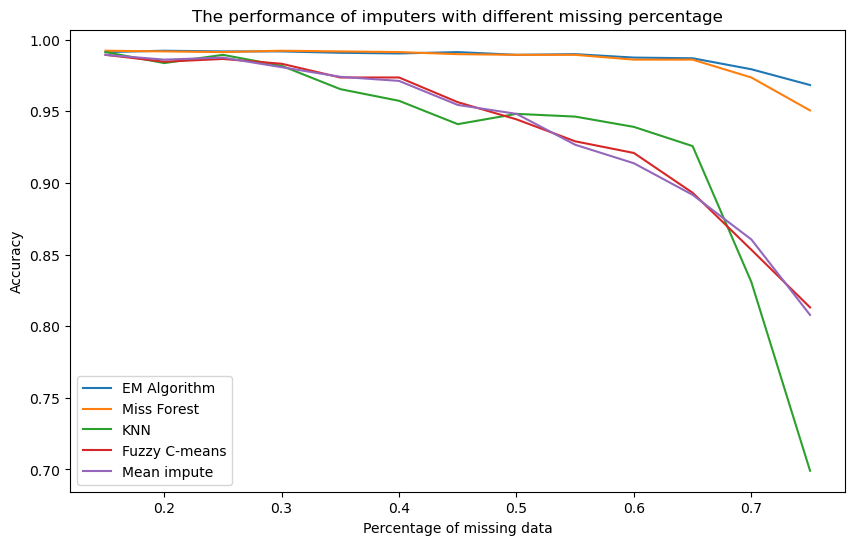

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6)) 
x = list(np.arange(0.15,0.76,0.05))

method_dict = {
    'em':'EM Algorithm',
    'miss':'Miss Forest',
    'knn':'KNN',
    'fcm':'Fuzzy C-means',
    'mean':'Mean impute'
}
for methods in ['em','miss','knn','fcm','mean']:
    y = [ele[0] for ele in result[methods]]
    plt.plot(x, y, label=method_dict[methods])

plt.xlabel('Percentage of missing data')
plt.ylabel('Accuracy')
plt.title('The performance of imputers with different missing percentage')
plt.legend()
plt.savefig('gas_impute_acc.png')

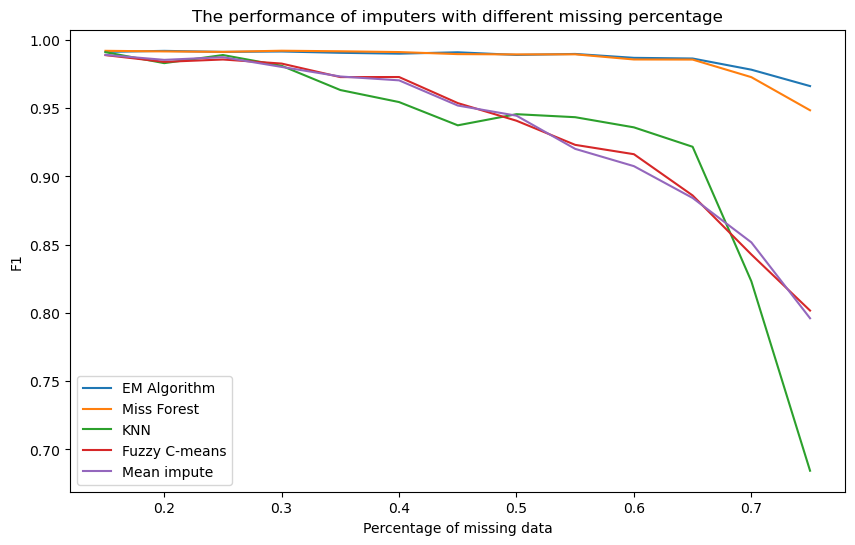

In [50]:
plt.figure(figsize=(10, 6)) 
method_dict = {
    'em':'EM Algorithm',
    'miss':'Miss Forest',
    'knn':'KNN',
    'fcm':'Fuzzy C-means',
    'mean':'Mean impute'
}
for methods in ['em','miss','knn','fcm','mean']:
    y = [ele[1] for ele in result[methods]]
    plt.plot(x, y, label=method_dict[methods])

plt.xlabel('Percentage of missing data')
plt.ylabel('F1')
plt.title('The performance of imputers with different missing percentage')
plt.legend()
plt.savefig('gas_impute_f1.png')

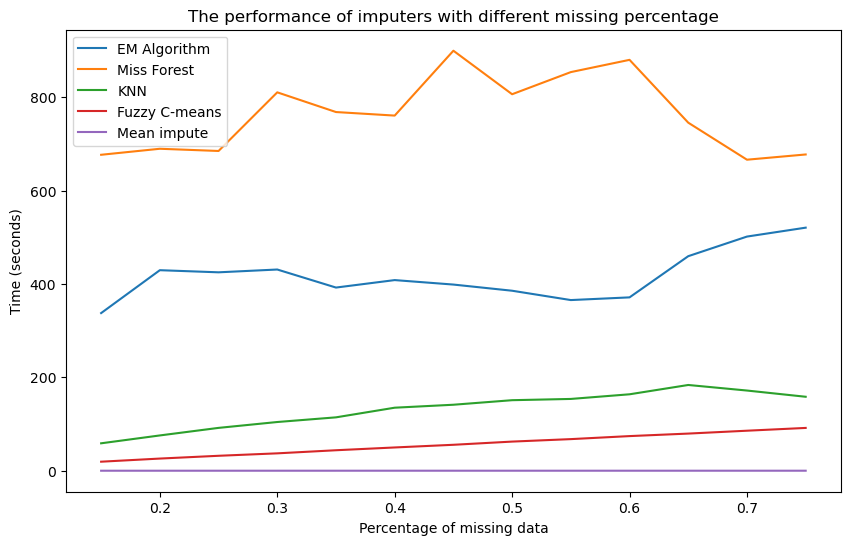

In [52]:
plt.figure(figsize=(10, 6)) 
method_dict = {
    'em':'EM Algorithm',
    'miss':'Miss Forest',
    'knn':'KNN',
    'fcm':'Fuzzy C-means',
    'mean':'Mean impute'
}

for methods in ['em','miss','knn','fcm','mean']:
    for ele in result[methods]:
        if type(ele[2]) != float:
            ele[2] = ele[2].total_seconds()
    y = [ele[2] for ele in result[methods]]
    plt.plot(x, y, label=method_dict[methods])

plt.xlabel('Percentage of missing data')
plt.ylabel('Time (seconds)')
plt.title('The performance of imputers with different missing percentage')
plt.legend(fontsize=10)
plt.savefig('gas_impute_time.png')